datetime     1
latitude     0
longitude    0
dtype: int64
                            datetime
count                           5837
mean   2022-06-26 14:33:51.098509568
min              2022-04-26 13:00:33
25%              2022-05-26 23:30:39
50%              2022-06-26 12:00:37
75%              2022-07-27 07:30:38
max              2022-08-27 02:00:41
                 date       x_stere       y_stere  data_gap_minutes  \
0 2022-04-27 00:00:00  735489.28728 -9.937636e+05              30.0   
1 2022-04-27 12:00:00  738131.40764 -9.986125e+05              30.0   
2 2022-04-28 00:00:00  741539.31266 -1.002340e+06              30.0   
3 2022-04-28 12:00:00  741618.18559 -1.004977e+06              30.0   
4 2022-04-29 00:00:00  741795.38069 -1.008320e+06              30.0   

   longitude  latitude              x             y         u         v  \
0   -8.49468  78.62311  735489.325117 -9.937638e+05       NaN       NaN   
1   -8.52978  78.57310  738131.358813 -9.986124e+05  0.070026 -0.0992

/Users/aless/miniconda3/envs/sea_ice_env/lib/python3.9/site-packages/icedrift/interpolation.py:110: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  tnew = pd.date_range(start=t.min().round(freq), end=t.max().round(freq), freq=freq).round(freq)
/Users/aless/miniconda3/envs/sea_ice_env/lib/python3.9/site-packages/icedrift/interpolation.py:110: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  tnew = pd.date_range(start=t.min().round(freq), end=t.max().round(freq), freq=freq).round(freq)


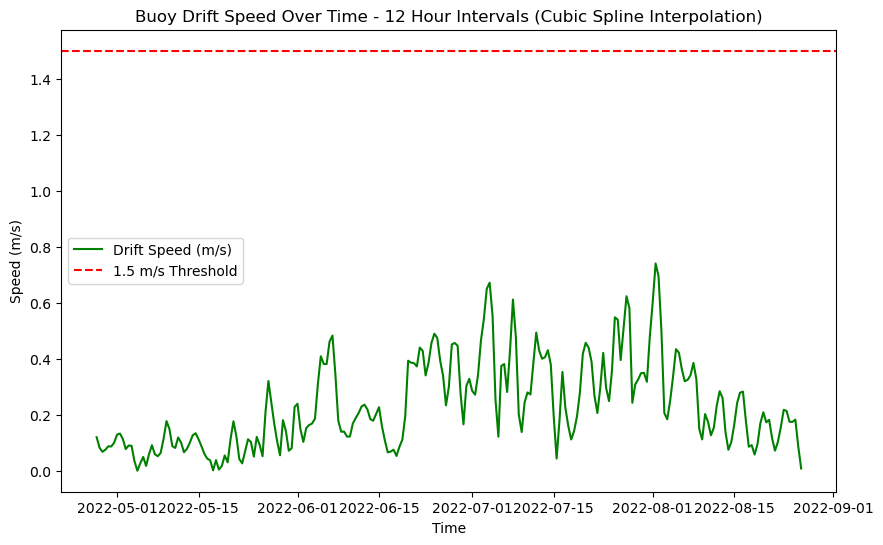

Cleaned DataFrame:
                      latitude  longitude  distance
datetime                                           
2022-04-26 13:30:39  78.662445  -8.326772  0.003809
2022-04-26 14:00:38  78.660459  -8.325376  0.002428
2022-04-26 14:30:39  78.658053  -8.326976  0.002889
2022-04-26 15:00:39  78.655400  -8.331420  0.005176
2022-04-26 15:30:27  78.652789  -8.339001  0.008018


In [1]:
import pandas as pd
import numpy as np
import pyproj
import sys
import matplotlib.pyplot as plt

from icedrift.analysis import compute_velocity
from icedrift.cleaning import check_positions, check_speed, check_gaps
from icedrift.interpolation import interpolate_buoy_track

# Define the path to the specific CSV file
file_path = "../../../data/buoy_data/cirfa2022/CIRFA22_206810.csv"
# Load the CSV file into a DataFrame
df = pd.read_csv(file_path, header=None, names=['datetime', 'latitude', 'longitude'])

# Convert 'datetime' column to a proper datetime object
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

# Check for missing or invalid values
print(df.isnull().sum())  # Check for missing data
print(df.describe())  # Check for outliers with summary statistics

# Convert latitude and longitude to numeric, drop invalid rows
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
df_cleaned = df.dropna(subset=['longitude', 'latitude'])

# Remove rows where latitude or longitude is outside the valid range
df_cleaned = df_cleaned[(df_cleaned['latitude'].between(-90, 90)) & (df_cleaned['longitude'].between(-180, 180))]

# Check for duplicated or nonphysical positions
flag_positions = check_positions(df_cleaned, pairs_only=True)
df_cleaned = df_cleaned[~flag_positions]

# Check for gaps in data (assumes sequential data)
flag_gaps = check_gaps(df_cleaned, threshold_gap='4h', threshold_segment=12)
df_cleaned = df_cleaned[~flag_gaps]

# Calculate drift distance between consecutive points
df_cleaned['distance'] = np.sqrt((df_cleaned['longitude'].diff()**2) + (df_cleaned['latitude'].diff()**2))

# Define a threshold for distance to filter out extreme jumps
threshold = 0.1  # Adjust this value based on your data
df_cleaned = df_cleaned[df_cleaned['distance'] < threshold]

# Set 'datetime' as the index for interpolation
df_cleaned.set_index('datetime', inplace=True)

# Use cubic spline interpolation with a 12-hour interval, and handle gaps up to 4 hours
df_resampled = interpolate_buoy_track(df_cleaned, freq='12H', maxgap_minutes=240)

# Reset index after interpolation
df_resampled.reset_index(inplace=True)

# Rename 'datetime' to 'date' for compatibility with compute_velocity
df_resampled.rename(columns={'datetime': 'date'}, inplace=True)

# Compute velocity using the interpolated data
df_velocity = compute_velocity(df_resampled, date_index=False)

# Print the results of the velocity calculation
print(df_velocity.head())

# Plot the drift speed as a time series
plt.figure(figsize=(10, 6))
plt.plot(df_velocity['date'], df_velocity['speed'], label='Drift Speed (m/s)', color='green')
plt.axhline(y=1.5, color='r', linestyle='--', label='1.5 m/s Threshold')
plt.xlabel('Time')
plt.ylabel('Speed (m/s)')
plt.title('Buoy Drift Speed Over Time - 12 Hour Intervals (Cubic Spline Interpolation)')
plt.legend()
plt.show()

# Final cleaned DataFrame is now ready for further analysis or plotting
print("Cleaned DataFrame:")
print(df_cleaned.head())


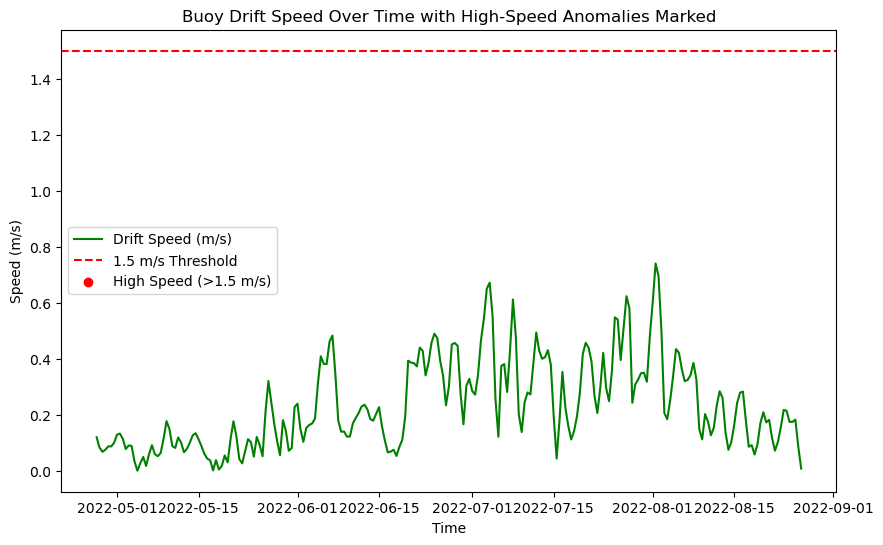

In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
# Plot drift speed with markers for high velocities
plt.figure(figsize=(10, 6))
plt.plot(df_velocity['date'], df_velocity['speed'], label='Drift Speed (m/s)', color='green')
plt.axhline(y=1.5, color='r', linestyle='--', label='1.5 m/s Threshold')

# Mark high velocities
high_speed = df_velocity[df_velocity['speed'] > 1.5]
plt.scatter(high_speed['date'], high_speed['speed'], color='red', label='High Speed (>1.5 m/s)', zorder=5)

plt.xlabel('Time')
plt.ylabel('Speed (m/s)')
plt.title('Buoy Drift Speed Over Time with High-Speed Anomalies Marked')
plt.legend()
plt.show()


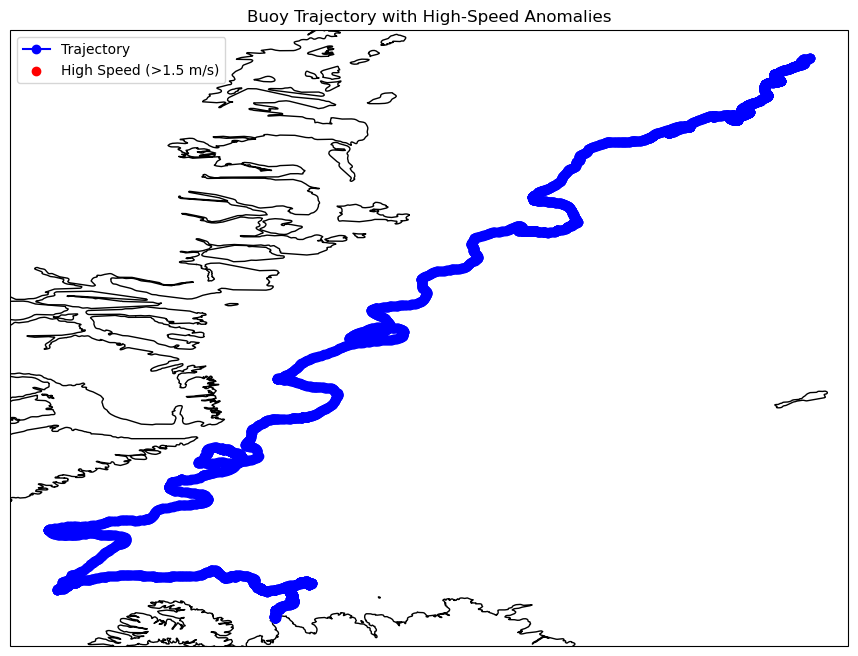

In [3]:
import cartopy.crs as ccrs

# Initialize the map
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

# Plot the trajectory
ax.plot(df_cleaned['longitude'], df_cleaned['latitude'], linestyle='-', marker='o', color='blue', label='Trajectory')

# Mark positions with high-speed anomalies
ax.scatter(df_resampled.loc[high_speed.index, 'longitude'], df_resampled.loc[high_speed.index, 'latitude'], 
           color='red', label='High Speed (>1.5 m/s)', zorder=5)

plt.title('Buoy Trajectory with High-Speed Anomalies')
plt.legend(loc='upper left')
plt.show()
